# *Brain Tumor Radiogenomic Classification* 
#### -> _3D CNN with PyTorch_

### Problem Description 
A malignant tumor in the brain is a life-threatening condition. Known as glioblastoma, it's both the most common form of brain cancer in adults and the one with the worst prognosis, with median survival being less than a year. The presence of a specific genetic sequence in the tumor known as MGMT promoter methylation has been shown to be a favorable prognostic factor and a strong predictor of responsiveness to chemotherapy. 

### Data Description

U.Baid, et al., “The RSNA-ASNR-MICCAI BraTS 2021 Benchmark on Brain Tumor Segmentation and Radiogenomic Classification”, arXiv:2107.02314, 2021.

### Outline
1. [Exploring the data](#exploring)

In [12]:
# !pip install pydicom

In [7]:
# necessary imports
import os
import sys
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [10]:
# sagemaker specific imports
import boto3
import sagemaker

# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

sagemaker_bucket = sagemaker_session.default_bucket()
print(sagemaker_bucket)

sagemaker-us-west-2-904606187431


<a id='exploring'></a>
### Exploring the Data

Training and test data structure is as follows:
1.  FLAIR - Fluid Attenuated Inversion Recovery
2.  T1w - T1-weighted pre-contrast
    * fluid (black) - low signal intensity
    * fat (white) - high signal intensity
    * grey matter (grey) - intermediate signal intensity
    * white matter (white-ish)
3.  T1wCE - T1-weighted post-contrast
4.  T2w - T2-weighted 
    * fluid (white) - high signal intensity
    * fat (white) - high signal intensity
    * grey matter (grey) - intermediate signal intensity
    * white matter (black-ish)

In [15]:
# project specific data paths
train_labels_key = 'train_labels.csv'

s3_prefix = 'Radiogenomic'
output_path = 's3://{}/{}/'.format(sagemaker_bucket, s3_prefix)
print('Model artifacts and data will be stored in ', output_path)

train_labels_df = pd.read_csv(os.path.join(output_path, train_labels_key))
print("Num train labels: ", len(train_labels_df))
train_labels_df.head()

Model artifacts and data will be stored in  s3://sagemaker-us-west-2-904606187431/Radiogenomic/
Num train labels:  585


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


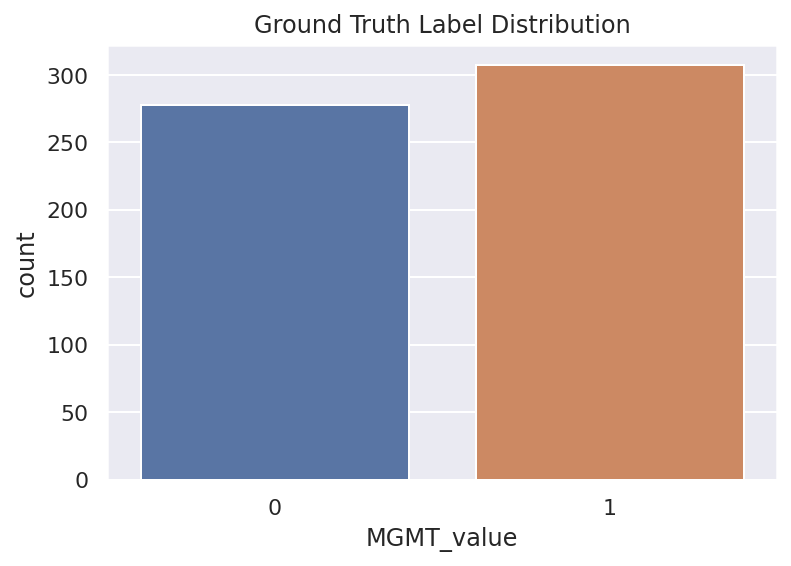

In [20]:
sns.countplot(data=train_labels_df, x='MGMT_value')
ax = sns.set_theme(style='darkgrid')
plt.title('Ground Truth Label Distribution')
plt.show()

#### Read in DICOM Images

In [55]:
import io 

test_image_path = os.path.join(s3_prefix, 'train/00000/FLAIR/Image-1.dcm', )
print(test_image_path)

s3client = boto3.client('s3')
test_img = s3client.get_object(Bucket=sagemaker_bucket, Key=test_image_path)
print(test_img['Body'])

test_data = pydicom.dcmread(io.BytesIO(test_img['Body'].read()))
print(test_data)

Radiogenomic/train/00000/FLAIR/Image-1.dcm
Dataset.file_meta -------------------------------
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.12945244209965516807097849901085909396
(0008, 0050) Accession Number                    SH: '00000'
(0008, 0060) Modality                            CS: 'MR'
(0008, 103e) Series Description                  LO: 'FLAIR'
(0010, 0010) Patient's Name                      PN: '00000'
(0010, 0020) Patient ID                          LO: '00000'
(0018, 0023) MR Acquisition Type                 CS: '3D'
(0018, 0050) Slice Thickness                     DS: '1.2'
(0018, 0081) Echo Time     